# Plot PCA of North African individuals

In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-e-16-229.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


# Helper Functions

In [9]:
def remove_individuals(df, remove_list=["_d"], iid_col="iid"):
    """Remove indivdiuals from PCA dataframe"""
    idx = df[iid_col].str.contains("|".join(remove_list))
    df = df[~idx].copy()
    print(f"Filtering to {len(df)}/{len(idx)}")
    return df

def get_sub_iid(df, pop_list=[""], iid_col="iid", output=True):
    """Remove indivdiuals from PCA dataframe"""
    pops = "|".join(pop_list)
    idx = df[iid_col].str.contains(pops)
    df = df[idx].copy()
    if output:
        print(f"{pops} IIDs: {len(df)}/{len(idx)}")
    return df

def get_sub_pops(df, pop_list=[], pop_col="pop"):
    """Get Sub Populations"""
    pops = "|".join(pop_list)
    idx = df[pop_col].str.contains(pops)
    df = df[idx].copy()
    print(f"{pops} Found: {len(df)}/{len(idx)}")
    return df

def get_sub_pops_exact(df, pop_list=[], pop_col="pop"):
    """Get Sub Populations"""
    idx = df[pop_col].isin(pop_list)
    df = df[idx].copy()
    print(f"Found {pop_list} (exact): {len(df)}/{len(idx)}")
    return df

def split_up_df(df, col="loc"):
    """Split up Dataframe by column.
    Return column labels and dataframes"""
    locs = [l for l, _ in df.groupby(col)]
    dfs = [df for _, df in df.groupby(col)]
    return locs, dfs

####################################################
### Plotting PCA

def plot_pca(ax, df, c="gray", alpha=1.0, legend="", marker="o",
             s=30, ec=None, text=False, pcs=["pc1", "pc3"]):
    """Plot PCA onto Axis"""
    ax.scatter(-df[pcs[0]], df[pcs[1]], c=c, alpha=alpha, label=legend, 
               ec=ec, s=s, marker=marker)
    if text:
        x, y = -df[pcs[0]].values, df[pcs[1]].values
        for i, txt in enumerate(df["iid"]):
            ax.annotate(txt, (x[i], y[i]), ha="left", va="bottom", c=c)
            
def plot_pca_ho(ax, df, c="gray", alpha=1.0, legend="", marker="o",
                s=30, ec=None, text=False, pcs=["pc1", "pc3"]):
    """Plot PCA onto Axis"""
    ax.scatter(-df[pcs[0]], df[pcs[1]], c=c, alpha=alpha, label=legend, 
               ec=ec, s=s, marker=marker)
    if text:
        x, y = -df[pcs[0]].values, df[pcs[1]].values
        for i in range(len(df)):
            if text==True:
                txt = df["iid"].values[i]
            else:
                txt=text
            ax.annotate(txt[:3], (x[i], y[i]), ha="center", va="center")  
            
###########################################################
### Helper Functions

def return_pca_matches(df, iid="I22119",
                       pcs = ["pc1", "pc2", "pc3", "pc4"]):
    """Return matches in pc space to sample iid.
    Report sorted dataframe"""
    pc_t = df[df["iid"]==iid][pcs]
    diffs = df[pcs]-pc_t.values
    diff_sq = np.sum(diffs**2,axis=1)
    idx = diff_sq.sort_values().index
    return df.iloc[idx,:].copy()

def save_pca_fig(savepath=""):
    """Save figures to savepath 
    (if given)"""
    if len(savepath) > 0:
        plt.savefig(savepath, bbox_inches = 'tight', 
                    pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
      
def generate_pc_df(path_pca="", path_meta="", min_snp=30000):
    """Generates the PCA dataframe. 
    path_pca: The evec file from the run.
    path_meta: The standard meta anno file with meta data"""
    df = pd.read_csv(path_pca, 
                     sep=r"\s+", skiprows=1, header=None)
    df.columns=["iid", "pc1", "pc2", "pc3", "pc4", "pop"]

    #####################################################
    ###
    idx = df["pop"].str.contains("construct_NAFR_PCA")
    print(f"Individuals used for PCs: {np.sum(idx)} / {len(idx)}")

    df = remove_individuals(df, remove_list=["_d"])

    df_meta = pd.read_csv(path_meta, sep=",")
    df2 = df_meta[["iid", "Master ID", "loc", "country", "n_cov_snp", 
                   "mean_cov", "sex", "age", "contact"]]
    df = pd.merge(df, df2, on="iid", how="left")
    idx = (df["n_cov_snp"]<min_snp)
    df = df[~idx]
    df.loc[df["loc"].isnull(), "loc"]="not assigned"
    print(f"Filtered to {len(df)} Individuals based on SNPs covered: {min_snp}")

    df = df.sort_values(by="n_cov_snp", ascending=False)
    dup = (df["Master ID"].duplicated() & ~df["Master ID"].isnull())
    df = df[~dup].copy().reset_index(drop=True)
    print(f"Filtered to {len(df)} based on duplicates")
    return df

In [3]:
df = generate_pc_df(path_pca = "./output/pca/v49.1/20210803.v49.1.construct_NAFR_PCA.smYES.outitY.evec.txt",
                    path_meta = "/n/groups/reich/hringbauer/Data/v46.3.HO.anno.csv", 
                    min_snp = 30000)
#df[:50]

Individuals used for PCs: 307 / 1826
Filtering to 1820/1826
Filtered to 1820 Individuals based on SNPs covered: 30000
Filtered to 1633 based on duplicates


# Plot the Background PCA

Found ['construct_NAFR_PCA'] (exact): 307/1633
Saved to: 


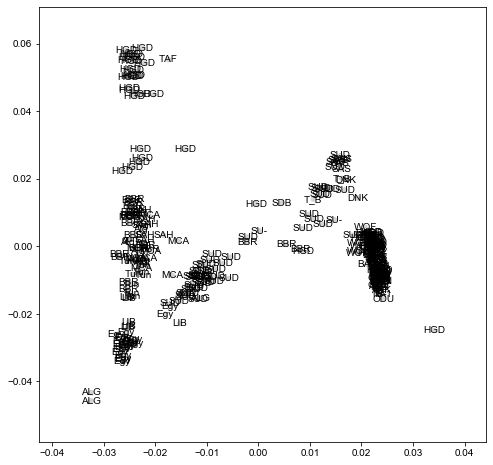

In [5]:
df_ho = get_sub_pops_exact(df, pop_list=["construct_NAFR_PCA"])

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=True,
            pcs=['pc1', 'pc3'])

#ax.set_xlim([0,0.04])
#ax.set_ylim([0.02,0.1])
save_pca_fig(savepath="")
plt.show()

In [8]:
df_ho1 = df_ho.reset_index(drop=True).copy()
df_ho1.to_csv("./output/share/nada.v46.3/projection_nafr.tsv", sep="\t", index=False)

In [ ]:
df_ho1

In [ ]:
df_ho.sort_values(by="pc1")[100:150]

# Plot background PCA with country labels

Found ['construct_NAFR_PCA'] (exact): 307/1633
Morocco: 40
Algeria: 39
Tunisia: 8
Libya: 6
Egypt: 22
Sudan: 60
Chad: 4
Nigeria: 60
Burkina Faso: 30
Senegal: 37
Saved to: 


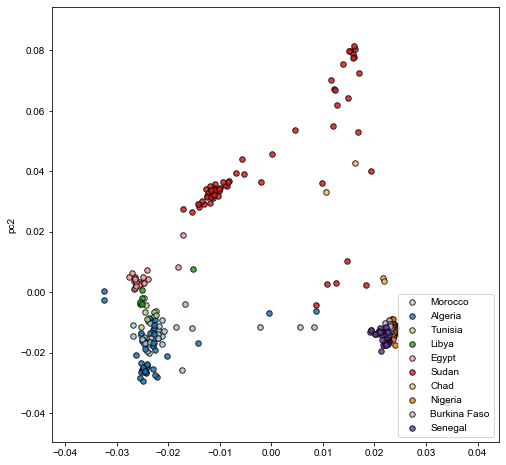

In [7]:
countries = ["Morocco", "Algeria", "Tunisia", "Libya", 
             "Egypt", "Sudan", "Chad", 
             "Nigeria", "Burkina Faso",
             "Senegal"]

colors = ["#a6cee3", "#1f78b4", "#b2df8a", "#33a02c",
         "#fb9a99", "#e31a1c", "#fdbf6f", "#ff7f00",
         "#cab2d6", "#6a3d9a", "#ffff99", "#b15928"]

pcs=["pc1","pc2"]

df_ho = get_sub_pops_exact(df, pop_list=["construct_NAFR_PCA"])

############################################

plt.figure(figsize=(8,8))
ax = plt.gca()
plot_pca_ho(ax, df_ho, c="lightgray", text=False, pcs=pcs)

for i, c in enumerate(countries):
    df_t = df_ho[df_ho["country"]==c]
    print(f"{c}: {len(df_t)}")
    plot_pca_ho(ax, df_t, c=colors[i], legend=c, 
                text=False, ec="k", alpha=0.8, pcs=pcs)
ax.legend(loc="lower right")
save_pca_fig(savepath="")

#ax.set_xlim([-0.04, -0.02])
#ax.set_ylim([-0.02, 0.04])
ax.set_ylabel(pcs[0])
ax.set_ylabel(pcs[1])

plt.show()

In [ ]:
df_ho.sort_values(by="pc1", ascending=False)[:50]

In [ ]:
#df["clst"].value_counts()

df["pop"].value_counts()[:50]

# Plot various Populations

Guanche Found: 4/1633
Tunisia_N Found: 4/1633
Morocco_Iberomaurusian Found: 6/1633
Morocco_EN Found: 3/1633
Morocco_LN Found: 3/1633
Nigeria_IA Found: 4/1633
Yoruba Found: 19/1633
Igbo Found: 29/1633
Bulala.DG|Laka.DG Found: 0/1633
Senegal_Modern Found: 4/1633
Sudan_EarlyChristian_R Found: 29/1633
Sudan_NileTransect_Shendi Found: 18/1633
Found ['Algeria_IA'] (exact): 1/1633
Egypt_Dynastic Found: 2/1633
Egypt_Medieval Found: 2/1633
Egypt_modern Found: 5/1633
Israel_Phoenician Found: 14/1633
Italy_Sardinia_Punic|Italy_Sardinia_IA_Punic Found: 27/1633
I21966|I21984|I22094|I22090|VIL011|VIL006|VIL009|VIL010|VIL007 IIDs: 9/1633
I18193|I18189|I22093 IIDs: 3/1633
Italy_Sardinia_C_oAfrica Found: 1/1633
Spain_EBA_Africa Found: 1/1633
Found ['construct_NAFR_PCA'] (exact): 307/1633
Found ['construct_NAFR_PCA'] (exact): 307/1633
Saved to: 


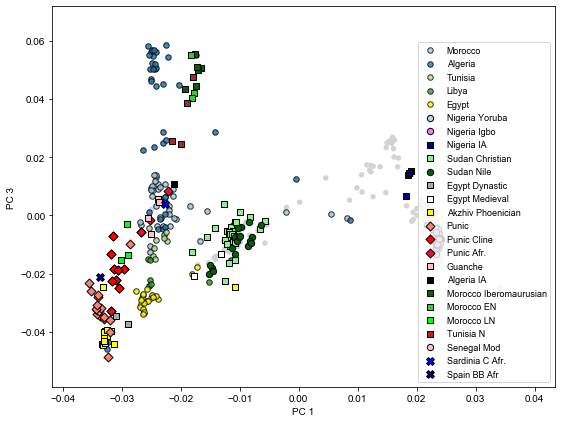

In [25]:
df_guanche = get_sub_pops(df, pop_list=["Guanche"])
df_tun_n = get_sub_pops(df, pop_list=["Tunisia_N"])
df_ib = get_sub_pops(df, pop_list=["Morocco_Iberomaurusian"])
df_mor_en = get_sub_pops(df, pop_list=["Morocco_EN"])
df_mor_ln = get_sub_pops(df, pop_list=["Morocco_LN"])

df_nig_ia = get_sub_pops(df, pop_list=["Nigeria_IA"])
df_yor = get_sub_pops(df, pop_list=["Yoruba"])
df_igbo = get_sub_pops(df, pop_list=["Igbo"])

df_cha_mo = get_sub_pops(df, pop_list=["Bulala.DG|Laka.DG"])
df_sen_mo = get_sub_pops(df, pop_list=["Senegal_Modern"])

df_sud_ch = get_sub_pops(df, pop_list=["Sudan_EarlyChristian_R"])
df_sud_nile = get_sub_pops(df, pop_list=["Sudan_NileTransect_Shendi"])

df_alg_ia = get_sub_pops_exact(df, pop_list=["Algeria_IA"])
df_eg_dyn = get_sub_pops(df, pop_list=["Egypt_Dynastic"])
df_eg_med = get_sub_pops(df, pop_list=["Egypt_Medieval"])
df_eg_mod = get_sub_pops(df, pop_list=["Egypt_modern"])


df_phoen = get_sub_pops(df, pop_list=["Israel_Phoenician"])
df_pun = get_sub_pops(df, pop_list=["Italy_Sardinia_Punic|Italy_Sardinia_IA_Punic"])
iids_afr_punic =  ["I18193", "I18189", "I22093"]  # "I22113" high but not high enough
iids_afr_cline = ["I21966", "I21984", "I22094", "I22090", "VIL011", "VIL006", "VIL009", "VIL010", "VIL007"]
df_pun_cline = get_sub_iid(df, iids_afr_cline)
df_pun_afr = get_sub_iid(df, iids_afr_punic)

df_sic_afr = get_sub_pops(df, pop_list=["Italy_Sardinia_C_oAfrica"])
df_spain_afr = get_sub_pops(df, pop_list=["Spain_EBA_Africa"])

df_ho = get_sub_pops_exact(df, pop_list=["construct_NAFR_PCA"])

plt.figure(figsize=(9,7))
ax = plt.gca()
plot_pca_ho(ax, df_ho, c="lightgray", text=False)

############################################
countries = ["Morocco", "Algeria", "Tunisia", "Libya", "Egypt"]
colors = ["#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "yellow"]
df_ho = get_sub_pops_exact(df, pop_list=["construct_NAFR_PCA"])

for i, c in enumerate(countries):
    df_t = df_ho[df_ho["country"]==c]
    plot_pca_ho(ax, df_t, c=colors[i], legend=c, text=False, ec="k", alpha=0.8)
############################################ 

plot_pca(ax, df_yor, c="lightblue", legend="Nigeria Yoruba", s=40, ec="k")
plot_pca(ax, df_igbo, c="violet", legend="Nigeria Igbo", s=40, ec="k")
plot_pca(ax, df_nig_ia, c="darkblue", legend="Nigeria IA", s=40, ec="k", marker='s')

plot_pca(ax, df_sud_ch, c="lightgreen", legend="Sudan Christian", s=40, ec="k", marker='s')
plot_pca(ax, df_sud_nile, c="darkgreen", legend="Sudan Nile", s=40, ec="k")

plot_pca(ax, df_eg_dyn, c="darkgray", legend="Egypt Dynastic", s=40, ec="k", marker='s')
plot_pca(ax, df_eg_med, c="white", legend="Egypt Medieval", s=40, ec="k", marker='s')

#### Phoenician/Punic
plot_pca(ax, df_phoen, c="yellow", legend="Akzhiv Phoenician", s=40, ec="k", marker='s')
plot_pca(ax, df_pun, c="salmon", legend="Punic", s=40, ec="k", marker='D')
plot_pca(ax, df_pun_cline, c="red", legend="Punic Cline", s=40, ec="k", marker='D')                       
plot_pca(ax, df_pun_afr, c="crimson", legend="Punic Afr.", s=40, ec="k", marker='D')   
                         

plot_pca(ax, df_guanche, c="pink", legend="Guanche", s=40, ec="k", marker='s')
plot_pca(ax, df_alg_ia, c="black", legend="Algeria IA", s=40, ec="k", marker='s')

plot_pca(ax, df_ib, c="darkgreen", legend="Morocco Iberomaurusian", s=40, ec="k", marker='s')
plot_pca(ax, df_mor_en, c="limegreen", legend="Morocco EN", s=40, ec="k", marker='s')
plot_pca(ax, df_mor_ln, c="lime", legend="Morocco LN", s=40, ec="k", marker='s')

plot_pca(ax, df_tun_n, c="brown", legend="Tunisia N", s=40, ec="k", marker='s')
plot_pca(ax, df_cha_mo, c="pink", legend="Senegal Mod", s=40, ec="k", marker='o')  

plot_pca(ax, df_sic_afr, c="blue", legend="Sardinia C Afr.", s=60, ec="k", marker='X')
plot_pca(ax, df_spain_afr, c="darkblue", legend="Spain BB Afr", s=60, ec="k", marker='X')  

#ax.set_xlim([-0.04, -0.005])
#ax.set_ylim([-0.015, 0.03])

ax.legend(loc="lower right", fontsize=9)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 3")
save_pca_fig(savepath="")
plt.show()

In [22]:
df_spain_afr = get_sub_pops(df, pop_list=["Spain"])

Spain Found: 31/1633


In [27]:
df_iid

,iid,pc1,pc2,pc3,pc4,pop,Master ID,loc,country,n_cov_snp,mean_cov,sex,age,contact
1458,I18201,0.036365,0.006724,0.032062,0.017851,Spain_Punic_o.3rd.degree.relative.cluster,I18201,"Almería, Cuevas del Almazora, Villaricos",Spain,NaN,NaN,M,2554.0,"Lalueza-Fox, Carles"


Found ['construct_NAFR_PCA'] (exact): 307/1633
Saved to: 


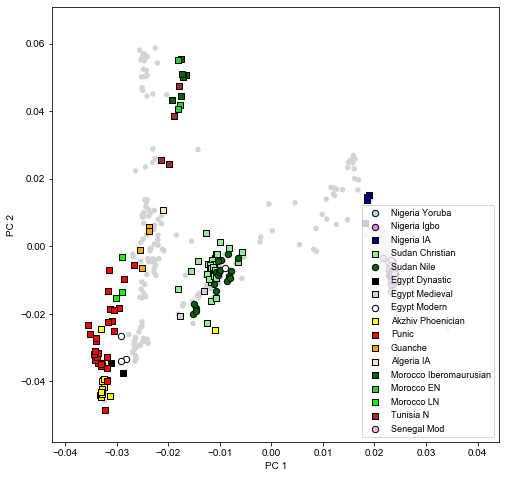

In [11]:
df_ho = get_sub_pops_exact(df, pop_list=["construct_NAFR_PCA"])

plt.figure(figsize=(8,8))
ax = plt.gca()
plot_pca_ho(ax, df_ho, c="lightgray", text=False)


plot_pca(ax, df_yor, c="lightblue", legend="Nigeria Yoruba", s=40, ec="k")
plot_pca(ax, df_igbo, c="violet", legend="Nigeria Igbo", s=40, ec="k")
plot_pca(ax, df_nig_ia, c="darkblue", legend="Nigeria IA", s=40, ec="k", marker='s')

plot_pca(ax, df_sud_ch, c="lightgreen", legend="Sudan Christian", s=40, ec="k", marker='s')
plot_pca(ax, df_sud_nile, c="darkgreen", legend="Sudan Nile", s=40, ec="k")

plot_pca(ax, df_eg_dyn, c="k", legend="Egypt Dynastic", s=40, ec="k", marker='s')
plot_pca(ax, df_eg_med, c="lightgray", legend="Egypt Medieval", s=40, ec="k", marker='s')
plot_pca(ax, df_eg_mod, c="white", legend="Egypt Modern", s=40, ec="k", marker='o')

#### Phoenician/Punic
plot_pca(ax, df_phoen, c="yellow", legend="Akzhiv Phoenician", s=40, ec="k", marker='s')
plot_pca(ax, df_pun, c="red", legend="Punic", s=40, ec="k", marker='s')

plot_pca(ax, df_guanche, c="orange", legend="Guanche", s=40, ec="k", marker='s')
plot_pca(ax, df_alg_ia, c="bisque", legend="Algeria IA", s=40, ec="k", marker='s')

plot_pca(ax, df_ib, c="darkgreen", legend="Morocco Iberomaurusian", s=40, ec="k", marker='s')
plot_pca(ax, df_mor_en, c="limegreen", legend="Morocco EN", s=40, ec="k", marker='s')
plot_pca(ax, df_mor_ln, c="lime", legend="Morocco LN", s=40, ec="k", marker='s')

plot_pca(ax, df_tun_n, c="brown", legend="Tunisia N", s=40, ec="k", marker='s')
plot_pca(ax, df_cha_mo, c="pink", legend="Senegal Mod", s=40, ec="k", marker='o')


ax.legend(loc="lower right", fontsize=9)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
save_pca_fig(savepath="")

plt.show()

Found ['construct_NAFR_PCA'] (exact): 299/1637
Saved to: 


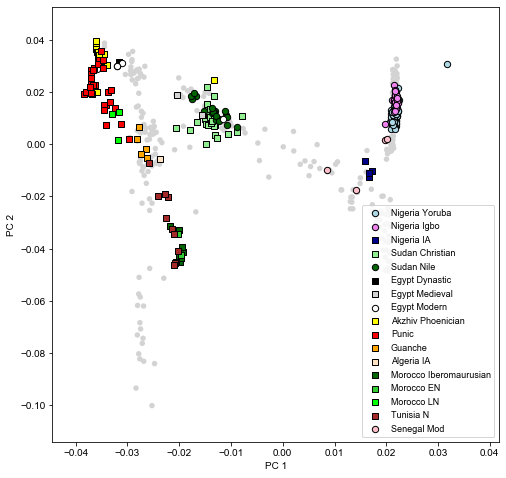

In [11]:
df_ho = get_sub_pops_exact(df, pop_list=["construct_NAFR_PCA"])

plt.figure(figsize=(8,8))
ax = plt.gca()
plot_pca_ho(ax, df_ho, c="lightgray", text=False)


plot_pca(ax, df_yor, c="lightblue", legend="Nigeria Yoruba", s=40, ec="k")
plot_pca(ax, df_igbo, c="violet", legend="Nigeria Igbo", s=40, ec="k")
plot_pca(ax, df_nig_ia, c="darkblue", legend="Nigeria IA", s=40, ec="k", marker='s')

plot_pca(ax, df_sud_ch, c="lightgreen", legend="Sudan Christian", s=40, ec="k", marker='s')
plot_pca(ax, df_sud_nile, c="darkgreen", legend="Sudan Nile", s=40, ec="k")

plot_pca(ax, df_eg_dyn, c="k", legend="Egypt Dynastic", s=40, ec="k", marker='s')
plot_pca(ax, df_eg_med, c="lightgray", legend="Egypt Medieval", s=40, ec="k", marker='s')
plot_pca(ax, df_eg_mod, c="white", legend="Egypt Modern", s=40, ec="k", marker='o')

#### Phoenician/Punic
plot_pca(ax, df_phoen, c="yellow", legend="Akzhiv Phoenician", s=40, ec="k", marker='s')
plot_pca(ax, df_pun, c="red", legend="Punic", s=40, ec="k", marker='s')

plot_pca(ax, df_guanche, c="orange", legend="Guanche", s=40, ec="k", marker='s')
plot_pca(ax, df_alg_ia, c="bisque", legend="Algeria IA", s=40, ec="k", marker='s')

plot_pca(ax, df_ib, c="darkgreen", legend="Morocco Iberomaurusian", s=40, ec="k", marker='s')
plot_pca(ax, df_mor_en, c="limegreen", legend="Morocco EN", s=40, ec="k", marker='s')
plot_pca(ax, df_mor_ln, c="lime", legend="Morocco LN", s=40, ec="k", marker='s')

plot_pca(ax, df_tun_n, c="brown", legend="Tunisia N", s=40, ec="k", marker='s')
plot_pca(ax, df_cha_mo, c="pink", legend="Senegal Mod", s=40, ec="k", marker='o')


ax.legend(loc="lower right", fontsize=9)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
save_pca_fig(savepath="")

plt.show()

# Plot Time Transect Tunisia N

Found ['construct_NAFR_PCA'] (exact): 307/1633
Saved to: 


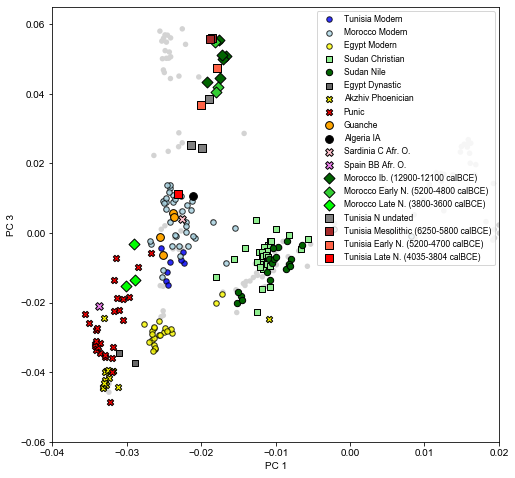

In [26]:
df_ho = get_sub_pops_exact(df, pop_list=["construct_NAFR_PCA"])

plt.figure(figsize=(8,8))
ax = plt.gca()
plot_pca_ho(ax, df_ho, c="lightgray", text=False)

df_t = df_ho[df_ho["country"]=="Tunisia"]
plot_pca_ho(ax, df_t, c="blue", legend="Tunisia Modern", text=False, ec="k", alpha=0.8)

df_t = df_ho[df_ho["country"]=="Morocco"]
plot_pca_ho(ax, df_t, c="lightblue", legend="Morocco Modern", text=False, ec="k", alpha=0.8)

df_t = df_ho[df_ho["country"]=="Egypt"]
plot_pca_ho(ax, df_t, c="yellow", legend="Egypt Modern", text=False, ec="k", alpha=0.8)

plot_pca(ax, df_sud_ch, c="lightgreen", legend="Sudan Christian", s=40, ec="k", marker='s')
plot_pca(ax, df_sud_nile, c="darkgreen", legend="Sudan Nile", s=40, ec="k")

plot_pca(ax, df_eg_dyn, c="dimgray", legend="Egypt Dynastic", s=40, ec="k", marker='s')
#plot_pca(ax, df_eg_med, c="lightgray", legend="Egypt Medieval", s=40, ec="k", marker='s')
#plot_pca(ax, df_eg_mod, c="white", legend="Egypt Modern", s=40, ec="k", marker='o')

#### Phoenician/Punic
plot_pca(ax, df_phoen, c="yellow", legend="Akzhiv Phoenician", s=40, ec="k", marker='X')
plot_pca(ax, df_pun, c="red", legend="Punic", s=40, ec="k", marker='X')

plot_pca(ax, df_guanche, c="orange", legend="Guanche", s=60, ec="k", marker='o')
plot_pca(ax, df_alg_ia, c="k", legend="Algeria IA", s=60, ec="k", marker='o')
plot_pca(ax, df_sic_afr, c="pink", legend="Sardinia C Afr. O.", s=60, ec="k", marker='X')
plot_pca(ax, df_spain_afr, c="violet", legend="Spain BB Afr. O.", s=60, ec="k", marker='X')  

plot_pca(ax, df_ib, c="darkgreen", legend="Morocco Ib. (12900-12100 calBCE)", s=60, ec="k", marker='D')
plot_pca(ax, df_mor_en, c="limegreen", legend="Morocco Early N. (5200-4800 calBCE)", s=60, ec="k", marker='D')
plot_pca(ax, df_mor_ln, c="lime", legend="Morocco Late N. (3800-3600 calBCE)", s=60, ec="k", marker='D')

plot_pca(ax, df_tun_n, c="gray", legend="Tunisia N undated", s=80, ec="k", marker='s')

df_iid = get_sub_iid(df, ["I20824|I20825"], output=False)
plot_pca(ax, df_iid, c="brown", legend="Tunisia Mesolithic (6250-5800 calBCE)", ec="k", s=80, marker="s")

df_iid = get_sub_iid(df, ["I22866|I22580"], output=False)
plot_pca(ax, df_iid, c="tomato", legend="Tunisia Early N. (5200-4700 calBCE)", ec="k", s=80, marker="s")

df_iid = get_sub_iid(df, ["I22852"], output=False)
plot_pca(ax, df_iid, c="red", legend="Tunisia Late N. (4035-3804 calBCE)", ec="k", s=80, marker="s")



ax.set_xlim([-0.04, 0.02])
ax.set_ylim([-0.06, 0.065])
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 3")

ax.legend(loc="upper right", fontsize=8.5)
save_pca_fig(savepath="")

plt.show()

Found ['construct_NAFR_PCA'] (exact): 299/1637
Saved to: ./figures/pca.v46/tunisia_n.png


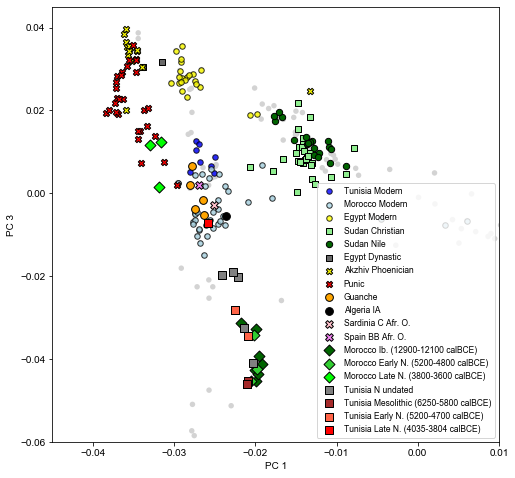

In [67]:
df_ho = get_sub_pops_exact(df, pop_list=["construct_NAFR_PCA"])

plt.figure(figsize=(8,8))
ax = plt.gca()
plot_pca_ho(ax, df_ho, c="lightgray", text=False)

df_t = df_ho[df_ho["country"]=="Tunisia"]
plot_pca_ho(ax, df_t, c="blue", legend="Tunisia Modern", text=False, ec="k", alpha=0.8)

df_t = df_ho[df_ho["country"]=="Morocco"]
plot_pca_ho(ax, df_t, c="lightblue", legend="Morocco Modern", text=False, ec="k", alpha=0.8)

df_t = df_ho[df_ho["country"]=="Egypt"]
plot_pca_ho(ax, df_t, c="yellow", legend="Egypt Modern", text=False, ec="k", alpha=0.8)

plot_pca(ax, df_sud_ch, c="lightgreen", legend="Sudan Christian", s=40, ec="k", marker='s')
plot_pca(ax, df_sud_nile, c="darkgreen", legend="Sudan Nile", s=40, ec="k")

plot_pca(ax, df_eg_dyn, c="dimgray", legend="Egypt Dynastic", s=40, ec="k", marker='s')
#plot_pca(ax, df_eg_med, c="lightgray", legend="Egypt Medieval", s=40, ec="k", marker='s')
#plot_pca(ax, df_eg_mod, c="white", legend="Egypt Modern", s=40, ec="k", marker='o')

#### Phoenician/Punic
plot_pca(ax, df_phoen, c="yellow", legend="Akzhiv Phoenician", s=40, ec="k", marker='X')
plot_pca(ax, df_pun, c="red", legend="Punic", s=40, ec="k", marker='X')

plot_pca(ax, df_guanche, c="orange", legend="Guanche", s=60, ec="k", marker='o')
plot_pca(ax, df_alg_ia, c="k", legend="Algeria IA", s=60, ec="k", marker='o')
plot_pca(ax, df_sic_afr, c="pink", legend="Sardinia C Afr. O.", s=60, ec="k", marker='X')
plot_pca(ax, df_spain_afr, c="violet", legend="Spain BB Afr. O.", s=60, ec="k", marker='X')  

plot_pca(ax, df_ib, c="darkgreen", legend="Morocco Ib. (12900-12100 calBCE)", s=60, ec="k", marker='D')
plot_pca(ax, df_mor_en, c="limegreen", legend="Morocco Early N. (5200-4800 calBCE)", s=60, ec="k", marker='D')
plot_pca(ax, df_mor_ln, c="lime", legend="Morocco Late N. (3800-3600 calBCE)", s=60, ec="k", marker='D')

plot_pca(ax, df_tun_n, c="gray", legend="Tunisia N undated", s=80, ec="k", marker='s')

df_iid = get_sub_iid(df, ["I20824|I20825"], output=False)
plot_pca(ax, df_iid, c="brown", legend="Tunisia Mesolithic (6250-5800 calBCE)", ec="k", s=80, marker="s")

df_iid = get_sub_iid(df, ["I22866|I22580"], output=False)
plot_pca(ax, df_iid, c="tomato", legend="Tunisia Early N. (5200-4700 calBCE)", ec="k", s=80, marker="s")

df_iid = get_sub_iid(df, ["I22852"], output=False)
plot_pca(ax, df_iid, c="red", legend="Tunisia Late N. (4035-3804 calBCE)", ec="k", s=80, marker="s")



ax.set_xlim([-0.045, 0.01])
ax.set_ylim([-0.06, 0.045])
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 3")

ax.legend(loc="lower right", fontsize=8.5)
save_pca_fig(savepath="./figures/pca.v46/tunisia_n.png")

plt.show()

In [61]:
df_sud_nile

,iid,pc1,pc2,pc3,pc4,pop,Master ID,loc,country,n_cov_snp,mean_cov,sex,age,contact
288,SUD-SHE86,0.016688,-0.028280,0.018377,0.014352,Sudan_NileTransect_Shendi,SUD-SHE86,Shendi // Arabic,Sudan,586575.0,0.488812,M,NaN,Garrett Hellenthal / Saioa Lopez / Mark Thomas...
291,SUD-SHE15,0.012219,-0.036805,0.009849,0.002529,Sudan_NileTransect_Shendi,SUD-SHE15,Shendi // Arabic,Sudan,586564.0,0.488803,M,NaN,Garrett Hellenthal / Saioa Lopez / Mark Thomas...
297,SUD-SHE6,0.017599,-0.027292,0.017501,0.009885,Sudan_NileTransect_Shendi,SUD-SHE6,Shendi // Arabic,Sudan,586537.0,0.488781,M,NaN,Garrett Hellenthal / Saioa Lopez / Mark Thomas...
299,SUD-SHE48,0.013619,-0.033752,0.011919,0.009718,Sudan_NileTransect_Shendi,SUD-SHE48,Elmisiktab // Arabic,Sudan,586533.0,0.488777,M,NaN,Garrett Hellenthal / Saioa Lopez / Mark Thomas...
300,SUD-SHE47,0.013081,-0.033570,0.012685,0.008191,Sudan_NileTransect_Shendi,SUD-SHE47,Hoosh Bannaga // Arabic,Sudan,586530.0,0.488775,M,NaN,Garrett Hellenthal / Saioa Lopez / Mark Thomas...
302,SUD-SHE13,0.010935,-0.040537,0.011263,0.008674,Sudan_NileTransect_Shendi,SUD-SHE13,Shendi // Arabic,Sudan,586519.0,0.488766,M,NaN,Garrett Hellenthal / Saioa Lopez / Mark Thomas...
310,SUD-SHE38,0.013292,-0.034454,0.012329,0.006873,Sudan_NileTransect_Shendi,SUD-SHE38,Kabushiyah-Shendi // Arabic,Sudan,586464.0,0.488720,M,NaN,Garrett Hellenthal / Saioa Lopez / Mark Thomas...
314,SUD-SHE49,0.008848,-0.040699,0.006668,0.006347,Sudan_NileTransect_Shendi,SUD-SHE49,Shendi // Arabic,Sudan,586453.0,0.488711,M,NaN,Garrett Hellenthal / Saioa Lopez / Mark Thomas...
317,SUD-SHE7,0.017756,-0.027704,0.018634,0.012958,Sudan_NileTransect_Shendi,SUD-SHE7,Shendi // Arabic,Sudan,586451.0,0.488709,M,NaN,Garrett Hellenthal / Saioa Lopez / Mark Thomas...
320,SUD-SHE26,0.015195,-0.031138,0.012754,0.006558,Sudan_NileTransect_Shendi,SUD-SHE26,Kabashia // Arabic,Sudan,586443.0,0.488702,M,NaN,Garrett Hellenthal / Saioa Lopez / Mark Thomas...
